In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import locale
import calendar
import math
locale.setlocale(locale.LC_TIME, 'es_ES')

'es_ES'

# Lectura de datos

In [2]:
# Cargar el archivo .nc utilizando xarray
data_boyaca = xr.open_dataset('../../data/data_boyaca_final.nc')
df_boyaca = data_boyaca.to_dataframe().reset_index(drop=True)

# Leer el shapefile con los municipios de Boyacá
gdf_boyaca = gpd.read_file('../../shapes/MGN_MPIO_POLITICO.shp')
# Seleccionar solo BOYACÁ
gdf_boyaca = gdf_boyaca[gdf_boyaca['DPTO_CNMBR'] == 'BOYACÁ']
# Dejar solo las columnas geometry y MPIO_CNMBR
gdf_boyaca = gdf_boyaca[['geometry', 'MPIO_CNMBR']]
# Renoimbrar la columna MPIO_CNMBR a municipio
gdf_boyaca.rename(columns={'MPIO_CNMBR': 'municipality'}, inplace=True)
# Capitalizar los nombres de los municipios
gdf_boyaca['municipality'] = gdf_boyaca['municipality'].str.title()
df_boyaca['municipality'] = df_boyaca['municipality'].str.title()

In [3]:
df_boyaca['time'] = pd.to_datetime(df_boyaca['time'])
df_boyaca['year'] = df_boyaca['time'].dt.year.astype(str)
df_boyaca['month'] = df_boyaca['time'].dt.month.apply(lambda x: calendar.month_name[x]).str.capitalize()

In [4]:

data = df_boyaca.copy()  # Asegurar que estamos trabajando con una copia
data['time'] = pd.to_datetime(data['time'])
data['year'] = data['time'].dt.year
data['month'] = data['time'].dt.month
# eliminar los datos del mes del mes 5 del año 2023
# data = data[~((data['year'] == 2023) & (data['month'] == 5))]

# Preprocesamiento de datos
data = data[['latitude', 'longitude', 'year', 'month', 'precip', 'municipality']]
data = data.dropna()

data.sample(5)

,latitude,longitude,year,month,precip,municipality
4277506,5.574997,-72.525002,1986,6,0.000000,Labranzagrande
11482703,6.924999,-72.075005,1991,8,0.000000,Cubará
10817801,6.674999,-72.225006,1994,12,26.672344,Güicán
3986001,5.574997,-73.475006,1994,3,5.025527,Sora
11408169,6.875000,-72.025002,1999,8,42.797672,Cubará


# convLSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Agregación mensual de precipitación
monthly_data = data.groupby(['latitude', 'longitude', 'year', 'month']).agg({'precip': 'sum'}).reset_index()

# Dividir datos en características y etiquetas
X = monthly_data[['latitude', 'longitude', 'year', 'month']].values
y = monthly_data['precip'].values

# Escalar características
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape de los datos para ConvLSTM
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, 1, X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, 1, X_test.shape[1], 1))

# Crear el modelo ConvLSTM
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1, 3), activation='relu', input_shape=(1, 1, X_train.shape[1], 1)))
model.add(Flatten())
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test),
                    epochs=100, batch_size=32, callbacks=[early_stopping])

# Evaluar el modelo
loss = model.evaluate(X_test_reshaped, y_test)
print(f'Loss en el conjunto de prueba: {loss}')

# Hacer predicciones
sample_input = np.array([[6.0249977112, -74.5250015259, 2023, 5]])  # Ejemplo de entrada (latitud, longitud, año, mes)
sample_input_scaled = scaler_X.transform(sample_input)
sample_input_reshaped = sample_input_scaled.reshape(1, 1, 1, sample_input_scaled.shape[1], 1)
prediction = model.predict(sample_input_reshaped)
print(f'Predicción de precipitación: {prediction[0][0]}')


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Agregación mensual de precipitación
monthly_data = data.groupby(['latitude', 'longitude', 'year', 'month']).agg({'precip': 'sum'}).reset_index()

# Dividir datos en características y etiquetas
X = monthly_data[['latitude', 'longitude', 'year', 'month']].values
y = monthly_data['precip'].values

# Escalar características
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape de los datos para ConvLSTM
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, 1, X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, 1, X_test.shape[1], 1))

# Crear el modelo ConvLSTM
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1, 3), activation='relu', input_shape=(1, 1, X_train.shape[1], 1)))
model.add(Flatten())
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test),
                    epochs=100, batch_size=32, callbacks=[early_stopping])


# Evaluar el modelo
loss = model.evaluate(X_test_reshaped, y_test)
print(f'Loss en el conjunto de prueba: {loss}')

# Crear una lista para almacenar las predicciones
predictions = []

# Hacer predicciones para todos los puntos únicos
unique_points = data[['latitude', 'longitude', 'municipality']].drop_duplicates()
for index, point in unique_points.iterrows():
    for month_offset in range(0, 12):  # Predicciones para los siguientes 12 meses a partir de junio de 2023
        year = 2023 if month_offset < 7 else 2024
        month = (6 + month_offset) % 12
        if month == 0:
            month = 12
        prediction_input = np.array([[point['latitude'], point['longitude'], year, month]])
        prediction_input_scaled = scaler_X.transform(prediction_input)
        prediction_input_reshaped = prediction_input_scaled.reshape(1, 1, 1, prediction_input_scaled.shape[1], 1)
        prediction = model.predict(prediction_input_reshaped)
        predictions.append({'latitude': point['latitude'],
                            'longitude': point['longitude'],
                            'municipality': point['municipality'],
                            'year': year,
                            'month': month,
                            'prediction': prediction[0][0]})

# Crear un DataFrame a partir de la lista de predicciones
prediction_data = pd.DataFrame(predictions)

# Guardar el DataFrame de predicciones en un archivo CSV
prediction_data.to_csv('predictions_ConvLSTM.csv', index=False)


Epoch 1/100
9582/9582 [==============================] - 45s 4ms/step - loss: 7952.4917 - val_loss: 5534.3950
Epoch 2/100
9582/9582 [==============================] - 43s 4ms/step - loss: 5354.6519 - val_loss: 5232.6182
Epoch 3/100
9582/9582 [==============================] - 41s 4ms/step - loss: 5110.9092 - val_loss: 4990.6060
Epoch 4/100
9582/9582 [==============================] - 41s 4ms/step - loss: 4831.8721 - val_loss: 4699.6841
Epoch 5/100
9582/9582 [==============================] - 40s 4ms/step - loss: 4581.0947 - val_loss: 4483.3979
Epoch 6/100
9582/9582 [==============================] - 41s 4ms/step - loss: 4382.3457 - val_loss: 4290.0083
Epoch 7/100
9582/9582 [==============================] - 46s 5ms/step - loss: 4194.5464 - val_loss: 4111.5732
Epoch 8/100
9582/9582 [==============================] - 46s 5ms/step - loss: 4040.3223 - val_loss: 3965.4507
Epoch 9/100
9582/9582 [==============================] - 46s 5ms/step - loss: 3919.3091 - val_loss: 3861.1533
Epoch 10/1

In [5]:
# Calcular las predicciones del modelo
y_pred_conv_lstm = model.predict(X_test_reshaped)
# Importar las funciones necesarias de scikit-learn para calcular las métricas
from sklearn.metrics import mean_squared_error, r2_score
# Calcular el Error Cuadrático Medio (MSE)
mse_conv_lstm = mean_squared_error(y_test, y_pred_conv_lstm)

# Calcular la Raíz del Error Cuadrático Medio (RMSE)
rmse_conv_lstm = np.sqrt(mse_conv_lstm)

# Calcular el Coeficiente de Determinación (R^2)
r2_conv_lstm = r2_score(y_test, y_pred_conv_lstm)

print(f'MSE del modelo ConvLSTM2D: {mse_conv_lstm}')
print(f'RMSE del modelo ConvLSTM2D: {rmse_conv_lstm}')
print(f'R^2 del modelo ConvLSTM2D: {r2_conv_lstm}')


2396/2396 [==============================] - 8s 3ms/step
MSE del modelo ConvLSTM2D: 3152.080078125
RMSE del modelo ConvLSTM2D: 56.14338684082031
R^2 del modelo ConvLSTM2D: 0.722161486960189


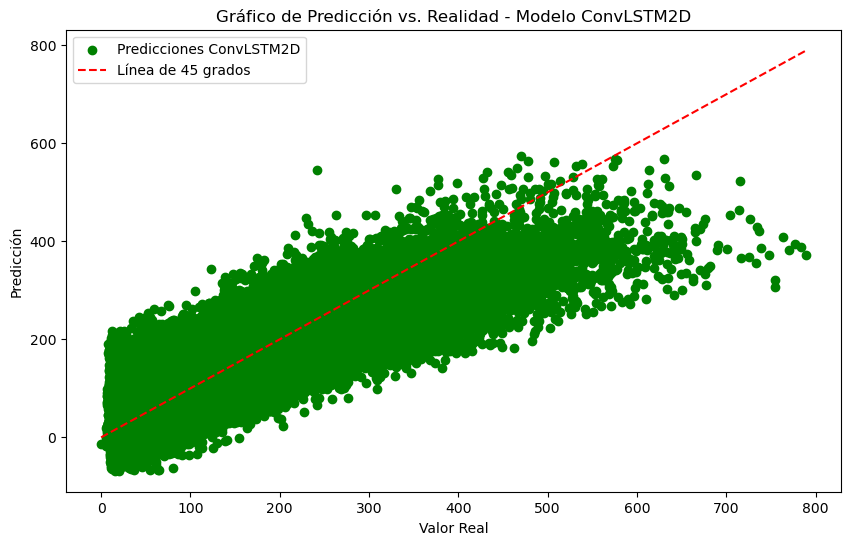

In [6]:
import matplotlib.pyplot as plt


# Gráfico de Predicción vs. Realidad para el modelo ConvLSTM2D
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_conv_lstm, color='green', label='Predicciones ConvLSTM2D')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Línea de 45 grados')
plt.xlabel('Valor Real')
plt.ylabel('Predicción')
plt.title('Gráfico de Predicción vs. Realidad - Modelo ConvLSTM2D')
plt.legend()
plt.show()


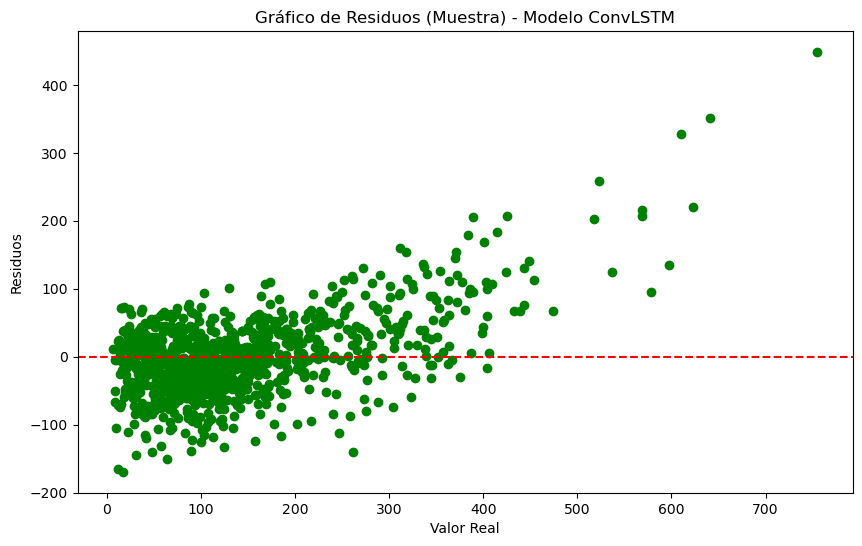

In [7]:
import random

# Elegir una muestra aleatoria de índices
sample_indices = random.sample(range(len(y_test)), k=1000)  # Cambia el valor de 'k' según lo necesites

# Crear una lista para almacenar los residuos de la muestra
sample_residues_conv_lstm = [y_test[i] - y_pred_conv_lstm[i] for i in sample_indices]

# Gráfico de Residuos para el modelo LSTM
plt.figure(figsize=(10, 6))
plt.scatter(y_test[sample_indices], sample_residues_conv_lstm, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Valor Real')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos (Muestra) - Modelo ConvLSTM')
plt.show()


